# Modeling
@Author: Bruno Vieira

Goals: Create a classification model able to identify a BOT account on twitter, using only profile-based features.

In [171]:
# Libs
import os
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score, average_precision_score, f1_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
import cloudpickle
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import utils.dev.model as mdl
import importlib
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [159]:
# Paths and Filenames
DATA_INPUT_PATH = 'data/interim'
DATA_INPUT_TRAIN_NAME = 'train_selected_features.csv'
DATA_INPUT_TEST_NAME = 'test.csv'
MODEL_OUTPUT_PATH = 'models'
MODEL_NAME = 'model_bot_classifier_v0.pkl'

In [132]:
df_twitter_train = pd.read_csv(os.path.join('..',DATA_INPUT_PATH, DATA_INPUT_TRAIN_NAME))
df_twitter_test = pd.read_csv(os.path.join('..',DATA_INPUT_PATH, DATA_INPUT_TEST_NAME))

In [97]:
df_twitter_train.replace({False:'FALSE', True:'TRUE'}, inplace=True)
df_twitter_test.replace({False:'FALSE', True:'TRUE'}, inplace=True)

# 1) Training

In [98]:
X_train = df_twitter_train.drop('label', axis=1)
y_train = df_twitter_train['label']
cat_columns = df_twitter_train.select_dtypes(include=['bool', 'object']).columns.tolist()
num_columns = df_twitter_train.select_dtypes(include=['int32','int64','float32', 'float64']).columns.tolist()
num_columns.remove('label')

In [99]:

skf = StratifiedKFold(n_splits=10)
cat_preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), 
                                   ('encoder', OneHotEncoder(handle_unknown='ignore'))])
num_preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
                                   ('scaler', StandardScaler())])

pipe_transformer = ColumnTransformer(transformers=[('num_pipe_preprocessor', num_preprocessor, num_columns),
                                                   ('cat_pipe_preprocessor', cat_preprocessor, cat_columns)])
pipe_model = Pipeline(steps=[('pre_processor', pipe_transformer), 
                             ('model', SVC(random_state=23, kernel='rbf', gamma='scale', C=1, probability=True))])

In [100]:
cross_validation_results = cross_validate(pipe_model, X=X_train, y=y_train, scoring=['average_precision', 'roc_auc', 'precision', 'recall'], cv=skf, n_jobs=-1, verbose=0, return_train_score=True)

In [101]:
pipe_model.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('num_pipe_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['name', 'followers_count',
                                                   'friends_count',
                                                   'listed_count',
                                                   'favourites_count',
                                                   'rate_friends_followers',
                                                   'unique_colors']),
                    

# 2) Evaluation

## 2.1) Cross Validation

In [102]:
cross_validation_results = pd.DataFrame(cross_validation_results)

In [107]:
cross_validation_results

,fit_time,score_time,test_average_precision,train_average_precision,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall
0,27.536970,1.862643,0.822254,0.717450,0.809445,0.685074,0.731343,0.643571,0.739224,0.708513
1,28.183174,1.752512,0.756801,0.719327,0.725310,0.689589,0.646681,0.645197,0.650862,0.701817
2,27.258845,1.896502,0.747670,0.727840,0.707189,0.692981,0.636917,0.645083,0.675269,0.702942
3,28.007198,1.733780,0.705080,0.710988,0.674730,0.682604,0.645749,0.644644,0.686022,0.702464
4,27.869060,1.722808,0.660182,0.718484,0.621055,0.689562,0.628283,0.644335,0.668817,0.722315
5,27.878100,1.718762,0.729675,0.715753,0.698297,0.685462,0.649225,0.640678,0.720430,0.723272
6,27.877697,1.762361,0.653986,0.727438,0.636221,0.694881,0.617934,0.648313,0.681720,0.712509
7,27.903750,1.729262,0.723285,0.722794,0.700169,0.690701,0.638489,0.645664,0.763441,0.703420
8,28.036855,1.710387,0.715701,0.717566,0.666471,0.690333,0.639929,0.638994,0.773707,0.728838
9,27.683651,1.765317,0.657866,0.725930,0.607402,0.698253,0.603416,0.651630,0.685345,0.697752


In [109]:
1.96*cross_validation_results['train_average_precision'].std()

0.010793214678570666

In [113]:
print(f"Avg Train Avg Precision:{np.round(cross_validation_results['train_average_precision'].mean(), 2)} +/- {np.round(1.96*cross_validation_results['train_average_precision'].std(), 2)}")
print(f"Avg Test Avg Precision:{np.round(cross_validation_results['test_average_precision'].mean(), 2)} +/- {np.round(1.96*cross_validation_results['test_average_precision'].std(), 2)}")

Avg Train Avg Precision:0.72 +/- 0.01
Avg Test Avg Precision:0.72 +/- 0.1


In [115]:
print(f"ROC - AUC Train:{np.round(cross_validation_results['train_roc_auc'].mean(), 2)} +/- {np.round(1.96*cross_validation_results['train_roc_auc'].std(), 2)}")
print(f"ROC - AUC Test:{np.round(cross_validation_results['test_roc_auc'].mean(), 2)} +/- {np.round(1.96*cross_validation_results['test_roc_auc'].std(), 2)}")

ROC - AUC Train:0.69 +/- 0.01
ROC - AUC Test:0.68 +/- 0.11


## 2.2) Test Set

In [133]:
def build_features(df):
    list_columns_colors = df.filter(regex='color').columns.tolist()
    df = df.replace({'false':'FALSE', 'true':'TRUE', False:'FALSE', True:'TRUE'})
    df['name'] = df['name'].apply(lambda x: len(x) if x is not np.nan else 0)
    df['profile_location'] = df['profile_location'].apply(lambda x: 'TRUE' if x is not np.nan else 'FALSE')
    df['rate_friends_followers'] = df['friends_count']/df['followers_count']
    df['rate_friends_followers'] = df['rate_friends_followers'].map({np.inf:0, np.nan:0})
    df['unique_colors'] = df[list_columns_colors].stack().groupby(level=0).nunique()
    return df

In [134]:
df_twitter_test = build_features(df_twitter_test)

In [136]:
columns_to_predict = df_twitter_train.columns.tolist()
df_twitter_test = df_twitter_test.loc[:,columns_to_predict]

In [138]:
X_test = df_twitter_test.drop('label', axis=1)
y_test = df_twitter_test['label']


## 2.3) Metrics

In [81]:
y_train_predict = pipe_model.predict_proba(X_train)
y_test_predict = pipe_model.predict_proba(X_test)

In [142]:
df_metrics_train = mdl.eval_thresh(y_real = y_train, y_proba = y_train_predict[:,1])
df_metrics_test = mdl.eval_thresh(y_real = y_test, y_proba = y_test_predict[:,1])


In [92]:
importlib.reload(mdl)

<module 'utils.dev.model' from '/Users/bruno.santos/Desktop/Mestrado/projects/bot_detection_twitter_profile_features/utils/dev/model.py'>

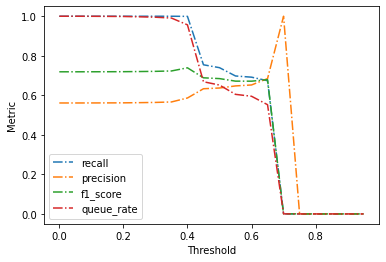

None

In [144]:
mdl.plot_metrics(df_metrics_train)

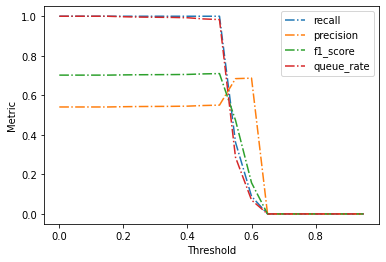

None

In [145]:
mdl.plot_metrics(df_metrics_test)

## 2.4) Learning Curve

In [163]:
train_sizes, train_scores, validation_scores = learning_curve(estimator = pipe_model,
                                                              X = X_train,
                                                              y = y_train,
                                                              cv = 5,
                                                              train_sizes=np.linspace(0.1, 1, 10),
                                                              scoring = 'neg_log_loss')

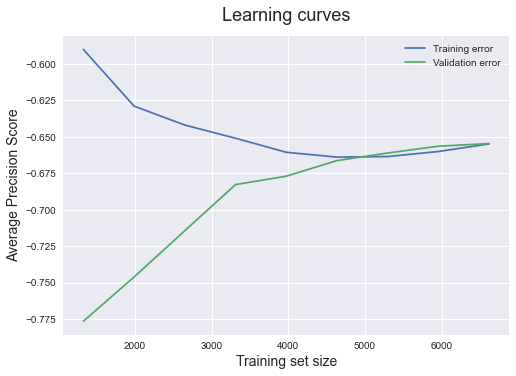

In [164]:
train_scores_mean = train_scores.mean(axis=1)
validation_scores_mean = validation_scores.mean(axis=1)
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Average Precision Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

## 2.5) Ordering

## 2.6) Callibration

# 3) Saving the Model

In [170]:
with open(os.path.join('..', MODEL_OUTPUT_PATH, MODEL_NAME), 'wb') as f:
    cloudpickle.dump(pipe_model, f)